In [1]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, cv2, os, random

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:
train_dataset = 'Dataset/Training/' 
test_dataset = 'Dataset/Testing/'

We now need to preprocess images within each folder and label them according to their classification.

In [ ]:
image_size_x, image_size_y = 224, 224

def preprocess_image(img_path):
    # read in the image
    if type(img_path) == np.ndarray:
        img = img_path
    else:
        img = cv2.imread(img_path)
        
    # convert image to grayscale
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # normalize the image array
    # img = img / 255

    # resize the image for uniformity
    img = cv2.resize(img, (image_size_x, image_size_y))

    return img

In [ ]:
encode = {'notumor': 0, 'meningioma': 1, 'glioma': 2, 'pituitary': 3}
decode = {0: 'notumor', 1: 'meningioma', 2: 'glioma', 3: 'pituitary'}

def load_data(dataset_path):
    x_data = [] # images
    y_data = [] # labels

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        # check if the path is a directory and skip if not
        if not os.path.isdir(folder_path):
            continue  
        
        for file in os.listdir(folder_path):
            # find path of the image
            file_path = os.path.join(folder_path, file)

            # preprocess the image
            img = preprocess_image(file_path)

            # append the new image to the x array
            x_data.append(img)

            # append the label to the y array
            y_data.append(encode[folder])
    
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    # shuffle data for better training
    x_data, y_data = shuffle(x_data, y_data, random_state=101)
    
    return x_data, y_data


In [ ]:
x_train, y_train = load_data(train_dataset)
x_test, y_test = load_data(test_dataset)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

Let us take a look at some images within our dataset.

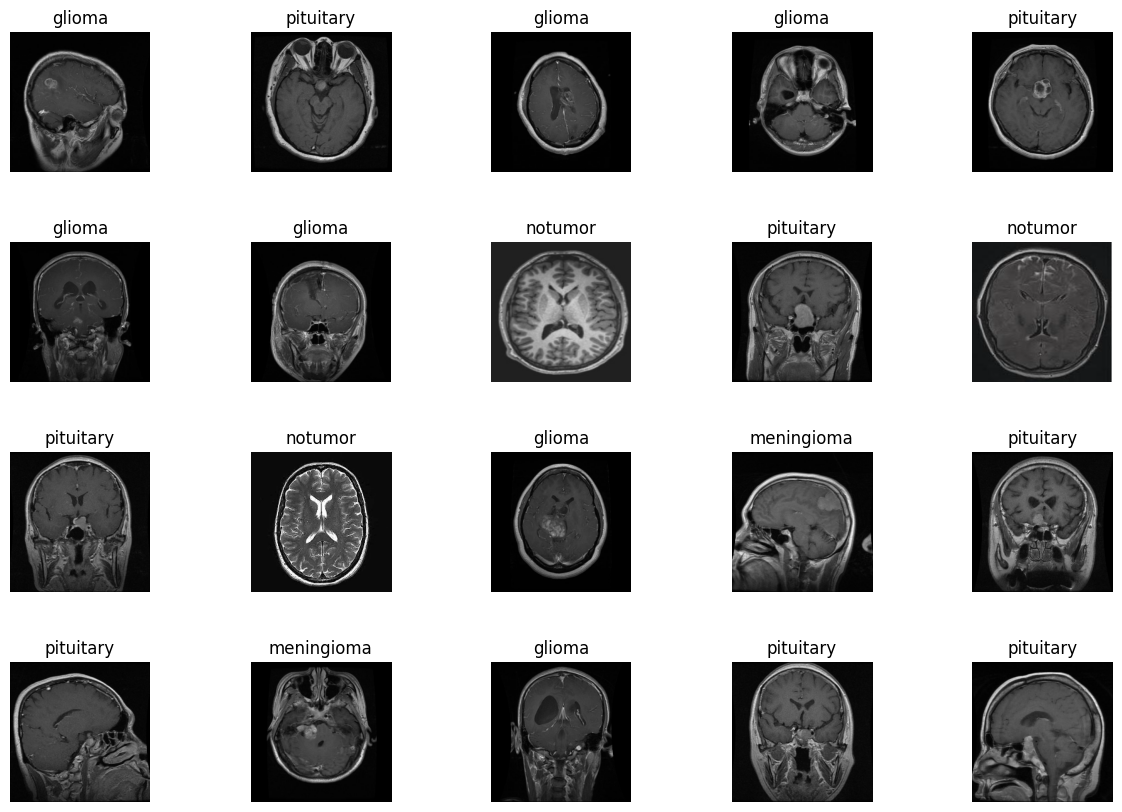

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.ravel()
for i in range(0, 20):
    index = random.randint(0, len(x_train))
    axes[i].imshow(x_train[index], cmap='gray')
    axes[i].set_title(decode[np.argmax(y_train[index])])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

Now with our data we can create our model.

In [ ]:
efficient_net = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size_x, image_size_y, 3))

In [ ]:
model = Sequential([
    efficient_net,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(4, activation='softmax') 
])

model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=6, validation_data=(x_test, y_test))

Epoch 1/4
90/90 [==============================] - 572s 6s/step - loss: 0.5105 - accuracy: 0.8200 - val_loss: 0.3454 - val_accuracy: 0.8772
Epoch 2/4
90/90 [==============================] - 536s 6s/step - loss: 0.1383 - accuracy: 0.9540 - val_loss: 0.1797 - val_accuracy: 0.9367
Epoch 3/4
90/90 [==============================] - 557s 6s/step - loss: 0.0788 - accuracy: 0.9720 - val_loss: 0.1476 - val_accuracy: 0.9481
Epoch 4/4
90/90 [==============================] - 541s 6s/step - loss: 0.0439 - accuracy: 0.9869 - val_loss: 0.0977 - val_accuracy: 0.9680


With this working model, we can evaluate the model and make our observations via the following metrics.

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.title('Neural Network Accuracy')
    plt.show()

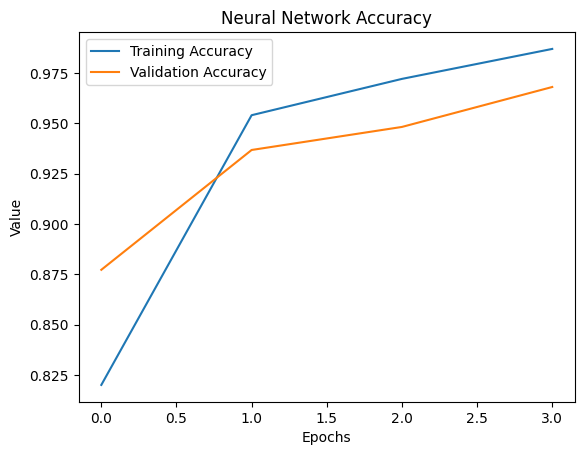

In [ ]:
plot_accuracy(history)

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title('Neural Network Loss')
    plt.show()

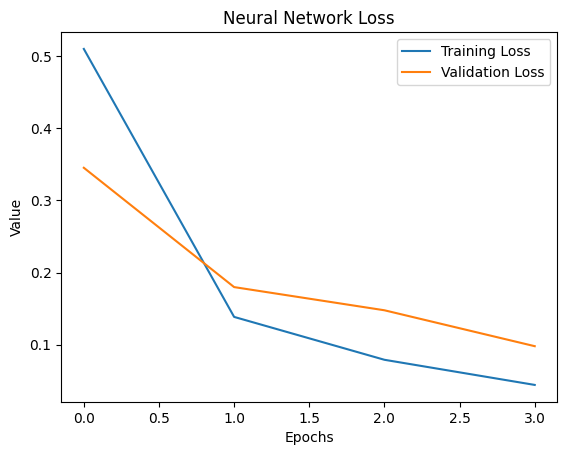

In [ ]:
plot_loss(history)

In [ ]:
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encode.keys())
    disp.plot()

41/41 [==============================] - 16s 394ms/step


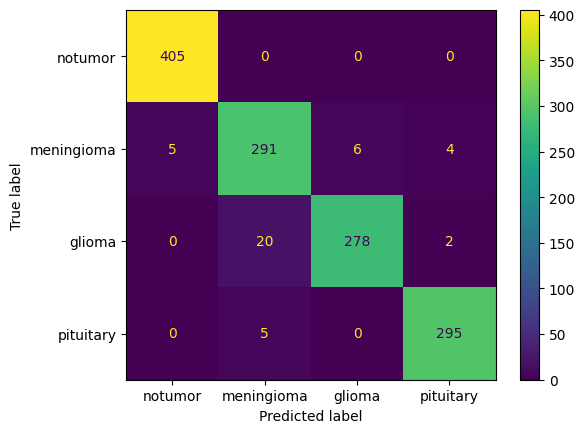

In [ ]:
plot_confusion_matrix(model, x_test, y_test)

Finally, we can use our model to make predictions on images outside of our dataset with the following function.

In [ ]:
def predict_image(model, img):
    img = preprocess_image(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    prediction = np.argmax(prediction)
    return decode[prediction]

1/1 [==============================] - 0s 31ms/step


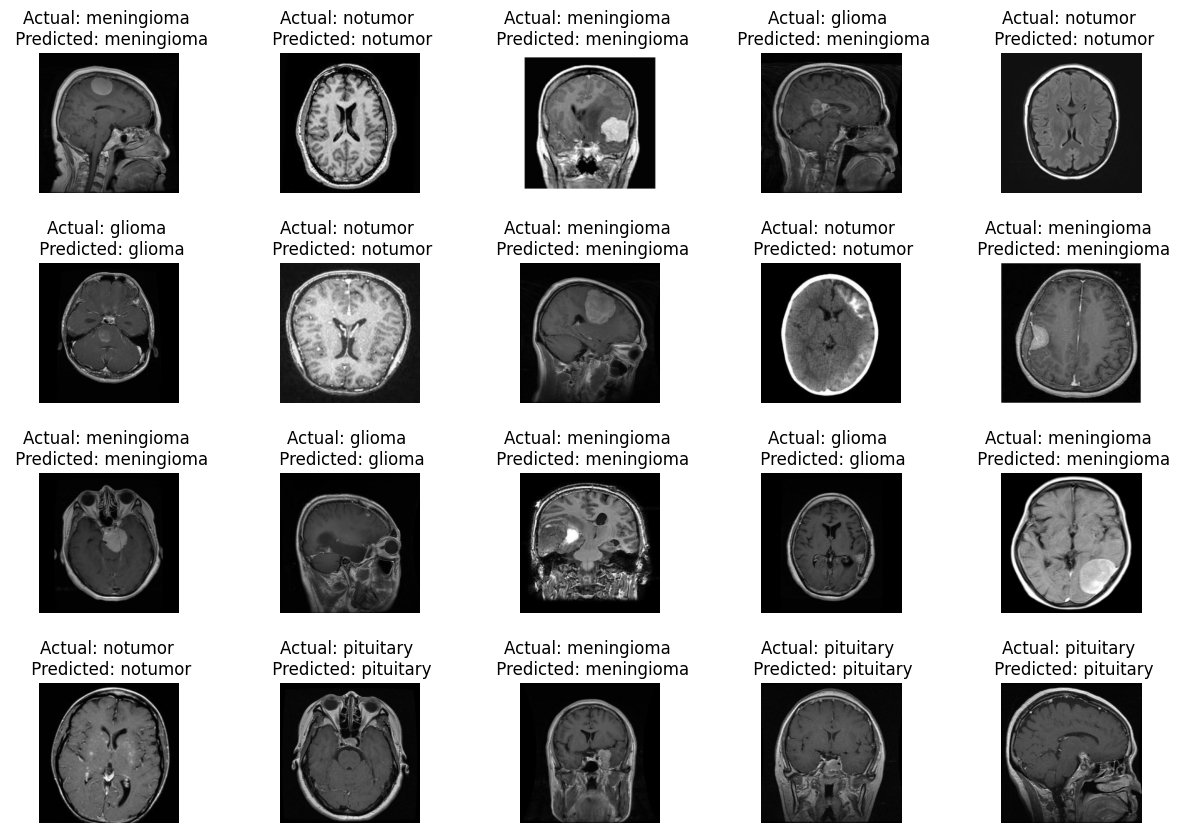

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.ravel()
for i in range(0, 20):
    index = random.randint(0, len(x_test))
    axes[i].imshow(x_test[index], cmap='gray')
    axes[i].set_title(f'Actual: {decode[np.argmax(y_test[index])]} \n Predicted: {predict_image(model, x_test[index])}')
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()